# Q-learning 

#### This version implements q-learning using a custom enviroment 1 day, with synthetic data, this version fix render method


In [1]:
# !pip install -r ./requirements.txt
# !pip install stable_baselines3[extra]
# !pip install yfinance
# !pip install talib-binary
# !pip install huggingface_sb3


In [2]:
import gym
from gym import spaces
from gym.utils import seeding

import talib as ta
from tqdm.notebook import tqdm

import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [3]:
def get_syntetic_data(tf, start_date, end_date, plot=True, add_noise=None):
    df = pd.date_range(start=start_date, end=end_date, freq=tf)
    df = df.to_frame()

    df['v1'] = np.arange(len(df.index))
    df[['Open','High','Low','Close','Volume']] = 0.0
    df = df.drop([0], axis=1)

    # adjust here the function to generate the data
    # df["Close"]=df["v1"].map(lambda x: np.sin(x)+10 ) # Simple sine wave all positive values 
    df["Close"]=df["v1"].map(lambda x: np.sin(x)+10 + np.sin(x/2) )  # a composition of 2 sine waves 
    if add_noise is not None: # could be 0.5
        noise = np.random.normal(0, add_noise, len(df))
        df["Close"] += noise

    if plot:
        plt.figure(figsize=(15,6))
        df['Close'].tail(30).plot()

    df["Open"]=df["Close"].shift(1)
    df = df.dropna()
    x = 1.5
    df["High"] = np.where( df["Close"] > df['Open'], df["Close"]+x, df["Open"]+x )
    df["Low"] = np.where( df["Close"] < df['Open'], df["Close"]-x, df["Open"]-x )
    df["Volume"] = 10
    return df

In [4]:
# Get data
eth_usd = yf.Ticker("ETH-USD")
eth = eth_usd.history(period="max")

btc_usd = yf.Ticker("BTC-USD")
btc = btc_usd.history(period="max")
print(len(btc))
print(len(eth))

btc_train = btc[-3015:-200]
btc_test = btc[-200:]
eth_train = eth[-1864:-200]
eth_test = eth[-200:]
# len(eth_train)

3080
1931


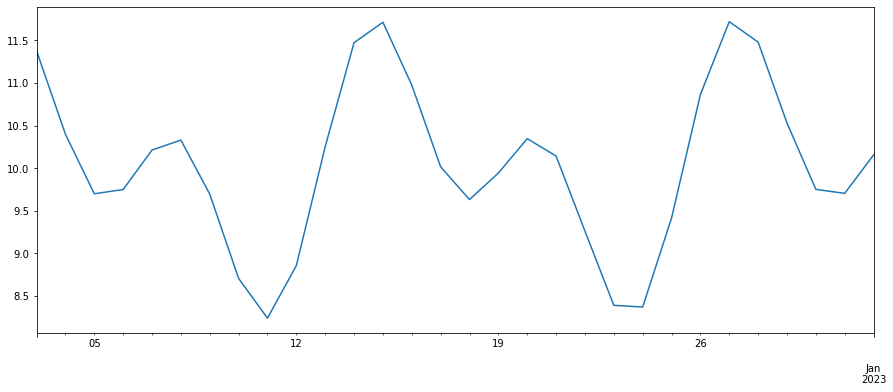

In [5]:
# use synthetic data
# synthetic_data = get_syntetic_data(tf="D", start_date="2015-01-01", end_date="2015-02-05", add_noise=None)
synthetic_data = get_syntetic_data(tf="D", start_date="2015-01-01", end_date="2023-01-01", add_noise=None)
eth_train = synthetic_data[-1864:-200]
eth_test = synthetic_data[-200:]

# eth_train = btc_train
# eth_test = btc_test


In [6]:
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [7]:
# Policy

def greedy_policy(Qtable, state):
    # Exploitation: take the action with the highest state, action value
    # if we dont have a state with values return DO_NOTHING 
    if abs(np.max(Qtable[state])) > 0:
        action = np.argmax(Qtable[state])
    else:
        action = 2
    # action = np.argmax(Qtable[state])
    return action


def epsilon_greedy_policy(Qtable, state, epsilon, env):
  # Randomly generate a number between 0 and 1
  random_num = np.random.uniform(size=1)
  # if random_num > greater than epsilon --> exploitation
  if random_num > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = greedy_policy(Qtable, state)
  # else --> exploration
  else:
    # action = np.random.random_integers(4,size=1)[0]
    action = env.action_space.sample()
  
  return action

In [8]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable, learning_rate, gamma):
  state_history = []
#   np.random.seed(42)
  for episode in range(n_training_episodes):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon, env)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, done, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * ( np.max(Qtable[new_state])  ) -  Qtable[state][action] )

      # If done, finish the episode
      if done:
        break
      
      # Our next state is the new state
      state = new_state

      state_history.append(state)  

  return Qtable, state_history

In [9]:
from enum import Enum
class Actions(Enum):
    Sell = 0
    Buy = 1
    Do_nothing = 2

class CustTradingEnv(gym.Env):

    def __init__(self, df, max_steps=0, random_start=True):
        self.seed()
        self.df = df
        self.prices, self.signal_features = self._process_data()

        # spaces
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=1999, shape=(1,) , dtype=np.float64)

        # episode
        self._start_tick = 0
        self._end_tick = 0
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None
        self._max_steps = max_steps
        self._start_episode_tick = None
        self._trade_history = None
        self._trade_tick_history = None
        self._random_start = random_start

    def reset(self):
        self._done = False
        if self._random_start:
            self._start_episode_tick = np.random.randint(1,high=len(self.df)- self._max_steps )
            self._end_tick = self._start_episode_tick + self._max_steps
        else:
            self._start_episode_tick = 1
            self._end_tick = len(self.df)-1
        # self._start_episode_tick = np.random.randint(1,len(self.df)- self._max_steps )
        # self._end_tick = self._start_episode_tick + self._max_steps
        self._current_tick = self._start_episode_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = 0
        self._position_history = [-1] * (len(self.prices)) 
        # self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 0.
        self._trade_history = []
        self._trade_tick_history = []
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position,
            action = action
        )
        self._update_history(info)

        return observation, step_reward, self._done, info

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
        
    def _get_observation(self):
        return self.signal_features[self._current_tick]

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):
        window_ticks = np.arange(len(self.prices))
        prices = self.prices
        # prices = self.prices[self._start_episode_tick:self._end_tick+1]
        plt.plot(prices)

        open_buy = []
        close_buy = []
        open_sell = []
        close_sell = []
        do_nothing = []
        penalty = []

        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == 1:
                open_buy.append(tick)
            elif self._position_history[i] == 2 :
                close_buy.append(tick)
            elif self._position_history[i] == 3 :
                open_sell.append(tick)
            elif self._position_history[i] == 4 :
                close_sell.append(tick)
            elif self._position_history[i] == 0 :
                do_nothing.append(tick)
            elif self._position_history[i] == 5 :
                penalty.append(tick)

        plt.plot(open_buy, prices[open_buy], 'go', marker="^")
        plt.plot(close_buy, prices[close_buy], 'go', marker="v")
        plt.plot(open_sell, prices[open_sell], 'ro', marker="v")
        plt.plot(close_sell, prices[close_sell], 'ro', marker="^")
    
        plt.plot(do_nothing, prices[do_nothing], 'oc')
        plt.plot(penalty, prices[penalty], 'yo')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    # the action is taken when the market is off after the session ends and we receive the close price of the day
    # this will be the current price 
    def _calculate_reward(self, action):
        step_reward = 0

        current_price = self.prices[self._current_tick]
        last_price = self.prices[self._current_tick - 1]
        price_diff = current_price - last_price

        penalty = -1 * last_price * 0.01
        # OPEN BUY - 1
        if action == Actions.Buy.value and self._position == 0:
            self._position = 1
            step_reward += price_diff
            self._last_trade_tick = self._current_tick - 1
            self._position_history[self._current_tick-1]=1

        # CLOSE BUY - 2
        elif action == Actions.Sell.value and self._position > 0:
            self._position = 0
            step_reward += self.prices[self._current_tick-1] - self.prices[self._last_trade_tick] 
            self._total_profit += step_reward
            self._position_history[self._current_tick-1]=2
            self._trade_history.append(step_reward)
            self._trade_tick_history.append((self._last_trade_tick, self._current_tick-1, self.prices[self._last_trade_tick], self.prices[self._current_tick-1], step_reward))

        elif action == Actions.Buy.value and self._position > 0:
            step_reward += penalty
            self._position_history[self._current_tick-1]=5
        # CLOSE SELL - 4
        elif action == Actions.Buy.value and self._position < 0:
            self._position = 0
            step_reward += -1 * (self.prices[self._current_tick-1] - self.prices[self._last_trade_tick]) 
            self._total_profit += step_reward
            self._position_history[self._current_tick-1]=4
            self._trade_history.append(step_reward)
            self._trade_tick_history.append((self._last_trade_tick, self._current_tick-1, self.prices[self._last_trade_tick], self.prices[self._current_tick-1], step_reward))

        # OPEN SELL - 3
        elif action == Actions.Sell.value and self._position == 0:
            self._position = -1
            step_reward += -1 * price_diff
            self._last_trade_tick = self._current_tick - 1
            self._position_history[self._current_tick-1]=3

        elif action == Actions.Sell.value and self._position < 0:
            step_reward += penalty
            self._position_history[self._current_tick-1]=5

        # DO NOTHING - 0
        elif action == Actions.Do_nothing.value and self._position > 0:
            step_reward += price_diff
            self._position_history[self._current_tick-1]=0
        elif action == Actions.Do_nothing.value and self._position < 0:
            step_reward += -1 * price_diff
            self._position_history[self._current_tick-1]=0
        elif action == Actions.Do_nothing.value and self._position == 0:
            step_reward += -1 * abs(price_diff)
            self._position_history[self._current_tick-1]=0

        return step_reward

    def _do_bin(self,df):
        df = pd.cut(df,bins=[0,10,20,30,40,50,60,70,80,90,100],labels=False, include_lowest=True)
        return df
    # Our state will be encode with 4 features MFI and Stochastic(only D line), ADX and DI+DI-
    # the values of each feature will be binned in 10 bins, ex:
    # MFI goes from 0-100, if we get 25 will put on the second bin 
    # DI+DI-  if DI+ is over DI- set (1 otherwise 0) 
    # 
    # that will give a state space of 10(MFI) * 10(STOCH) * 10(ADX) * 2(DI) = 2000 states
    # encoded as bins of  DI MFI STOCH ADX = 1 45.2  25.4  90.1 , binned = 1 4 2 9 state = 1429   
    def _process_data(self):
        timeperiod = 14
        self.df = self.df.copy()
        
        self.df['adx_r'] = ta.ADX(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=timeperiod)
        self.df['mfi_r'] = ta.MFI(self.df['High'], self.df['Low'], self.df['Close'],self.df['Volume'], timeperiod=timeperiod)
        _, self.df['stock_d_r'] = ta.STOCH(self.df['High'], self.df['Low'], self.df['Close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
        self.df['p_di'] = ta.PLUS_DI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=timeperiod)
        self.df['m_di'] = ta.MINUS_DI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=timeperiod)
        self.df['di'] = np.where( self.df['p_di'] > self.df['m_di'], 1, 0)
        self.df = self.df.dropna()
        self.df['mfi'] = self._do_bin(self.df['mfi_r'])
        self.df['stock_d'] = self._do_bin(self.df['stock_d_r'])
        self.df['adx'] = self._do_bin(self.df['adx_r'])

        self.df['state'] = self.df['di']*1000+ self.df['mfi']*100 + self.df['stock_d']*10 + self.df['adx']

        prices = self.df.loc[:, 'Close'].to_numpy()
        signal_features = self.df.loc[:, 'state'].to_numpy()
        # signal_features = self.df.loc[:, ['di', 'mfi', 'stock_d','adx']].to_numpy()

        return prices, signal_features

In [10]:
# Training parameters
n_training_episodes = 20000  # Total training episodes
learning_rate = 0.2          # Learning rate

# Environment parameters
max_steps = 20   # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
# max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability 
# min_epsilon = 0.05            # Minimum exploration probability 
decay_rate = 0.0005            # Exponential decay rate for exploration prob

In [11]:
# create env
env = CustTradingEnv(df=eth_train, max_steps=max_steps, random_start=True)

In [12]:
# create q-table

action_space = env.action_space.n # buy sell do_nothing
state_space = 2000

Qtable_trading = initialize_q_table(state_space, action_space)

In [13]:
# train with ETH
Qtable_trading, state_history = train(n_training_episodes, min_epsilon, max_epsilon, 
                        decay_rate, env, max_steps, Qtable_trading, learning_rate, gamma )
len(np.where( Qtable_trading > 0 )[0])

# #train with BTC
# env = CustTradingEnv(df=btc_train, max_steps=max_steps)
# Qtable_trading, state_history = train(n_training_episodes, min_epsilon, max_epsilon, 
#                         decay_rate, env, max_steps, Qtable_trading, learning_rate, gamma )
# len(np.where( Qtable_trading > 0 )[0])

97

In [14]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, random=False):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  """
  episode_positive_perc_trades = []
  episode_rewards = []
  episode_profits = []
  for episode in tqdm(range(n_eval_episodes), disable=random):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    total_profit_ep = 0
    
    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      if random:
        action = env.action_space.sample()
      else:
        action = greedy_policy(Q, state)

      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
        
      if done:
        break
      state = new_state

    if len(env._trade_history) > 0:
        episode_positive_perc_trades.append(np.count_nonzero(np.array(env._trade_history) > 0)/len(env._trade_history))
    episode_rewards.append(total_rewards_ep)
    episode_profits.append(env.history['total_profit'][-1])
    # print(env.history)
    # env.render()
    # assert 0

  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)
  mean_profit = np.mean(episode_profits)
  std_profit = np.std(episode_profits)
  positive_perc_trades = np.mean(episode_positive_perc_trades)

  return mean_reward, std_reward, mean_profit, std_profit, positive_perc_trades

In [15]:
max_steps = 60 
env_test = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=True)
n_eval_episodes = 1000

evaluate_agent(env_test, max_steps, n_eval_episodes, Qtable_trading)

  0%|          | 0/1000 [00:00<?, ?it/s]

(24.435464104143733,
 5.499791149875003,
 18.5904204053222,
 2.3777410865463082,
 0.9845059065934068)

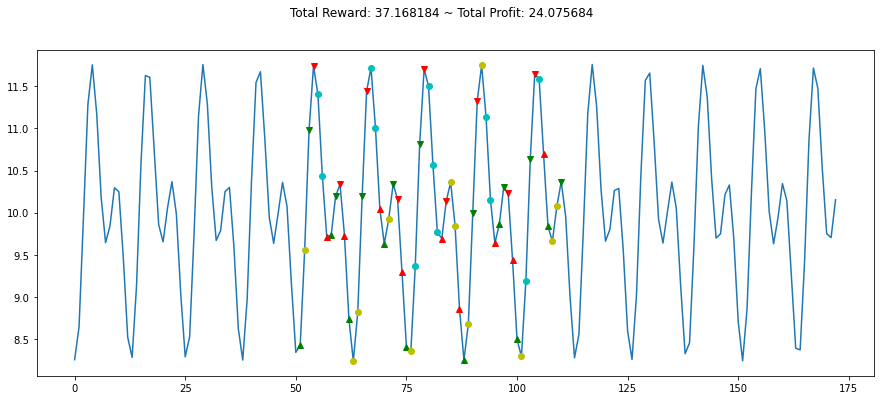

In [16]:
plt.figure(figsize=(15,6))
plt.cla()
env_test.render()

In [20]:
# trade sequential
max_steps = len(eth_test)
env_test = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=False)
n_eval_episodes = 1

evaluate_agent(env_test, max_steps, n_eval_episodes, Qtable_trading)

  0%|          | 0/1 [00:00<?, ?it/s]

(75.04391344152532, 0.0, 56.51131547865238, 0.0, 0.9761904761904762)

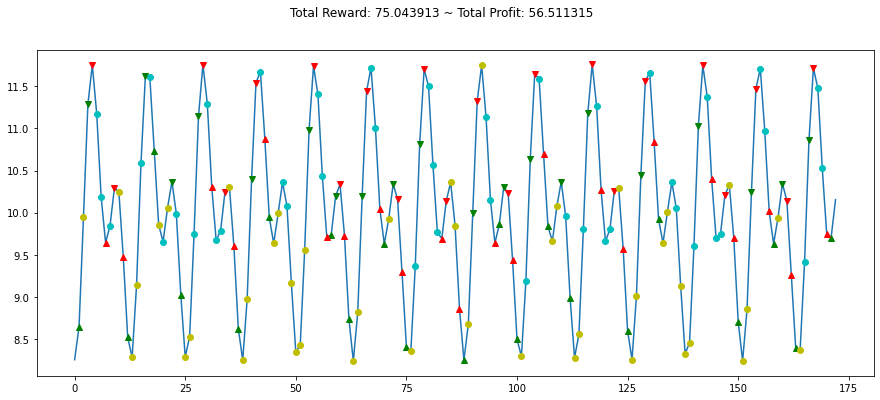

In [21]:
plt.figure(figsize=(15,6))
plt.cla()
env_test.render()

In [ ]:
env_test._trade_tick_history